# 1. Классификация изображений по стилям художников


In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms, models
from torch import optim, nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(1)


Необходимо загрузить датасет в DataLoader.   Предварительно было решено оставить 2 пайплайна: <br>
Простой препроцессинг (transform):<br>
1) Преобразовать изображения в размер 128х128 <br>
2) Нормализовать данные в соответствии со средними значениями и среднквадратическими отклонениями ImageNet <br>

Препроцессинг с аугментацией (transform_augmented):
1) Взять случайный кроп и преобразовать в размер 128х128 <br>
2) Горизонтальное отражение с вероятностью 50% <br>
3) Нормализовать данные в соответствии со средними значениями и среднквадратическими отклонениями ImageNet <br>


In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_augmented = transforms.Compose([transforms.RandomResizedCrop((128, 128), scale=(0.08, 1.0)),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

traindata = datasets.ImageFolder(root="./images",
                                 transform=transform_augmented)

valdata = datasets.ImageFolder(root="./images",
                               transform=transform)


В первую очередь нужно посмотреть какие есть классы и сколькими изображениями они представлены. 

<AxesSubplot:>

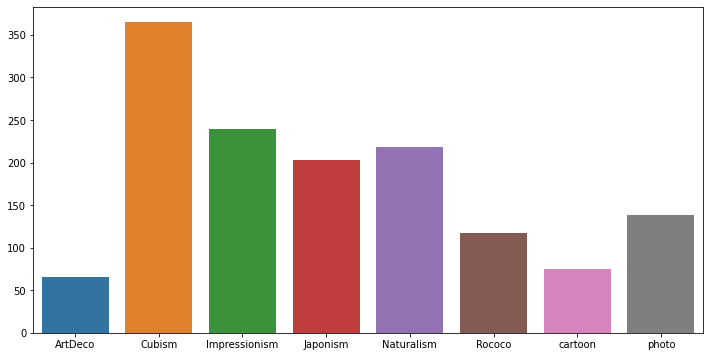

In [111]:
classes = traindata.classes
num_classes = len(traindata.classes)
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0

for i in range(len(traindata)):
    img, label = traindata[i]
    img_dict[classes[label]] += 1

plt.figure(figsize=(12, 6))
sns.barplot(x=list(img_dict.keys()), y=list(img_dict.values()))


Как можно заметить, данные дисбалансы, арт-деко и мультфильмы слабо представлены, кубизм избыточно представлен. 
Есть различные решения, к которым можно прибегнуть, но в данном задании будет достаточно использовать различные веса для каждого класса в соответствии с их представленностью в данных. Для этого используем метод compute_class_weight из sklearn. 

In [112]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(traindata.targets), y=traindata.targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

Для равномерного распределения данных в тренировочной и валидационной выборках необходимо также использовать stratify в train_test_split. 

In [113]:
targets = traindata.targets
train_idx, test_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets,
    random_state=1)

Выбрав индексы для тренировочной и валидационной выборок, можно создать соответствующие DataLoader'ы.

In [114]:
batch_size = 32
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, sampler=valid_sampler)

В рамках задания изначально хотелось проверить исходные данные на классических моделях, используемых в задачах классификации изображений. Выбор осуществлялся исходя из набора возможных моделей ```torchvision.models```. Основным критерием была совокупность размера модели и результаты accuracy с бенчмарков в документации PyTorch. Из наиболее подходящих можно выделить **Resnet18** и **EfficientNet B0**. **Resnet18** выбран так как из-за простоты архитектуры с ней значительно проще и быстрее проводить эксперименты в контексте текущего задания.


*Забегая вперед скажу что в процессе выполнения задачи была реализована модель Resnet18 на которой предпринимались попытки избежать переобучения (добавление Dropout'ов, регуляризация, изменение/удаление слоев в архитектуре для упрощения модели). В среднем показатели измеряемых метрик стали лучше после большинства экспериментов, но всё же отставали от предобученной модели. В приложении оставлю реализацию модели Resnet18. Если исходить из всех проведенных экспериментов сложилось ощущение малой репрезентативности (или сложности обобщения данных) классов в данных: Validation loss или прыгал волнами или не опускался определенного значения, в случае переобучения Validation loss иногда поднимался.*

Функцией ошибки была выбрана **Cross Entropy Loss**, как весьма часто используемая функция ошибки при многоклассовой классификации, демонстрируя разницу между распределением вероятности истины и предсказания модели для всех классов. Для оценки качества модели в течение времени отслеживаются **Train loss** и **Validation loss**, помимо этого для оценки работы классификатора используется примитивный **Accuracy**, который скорее нужен для мониторинга состояния и подсчета корректных классификаций. <br>

Финальная модель выбирается на основе минимального значения **Validation loss**, чтобы не получить переобученную на тренировочных данных модель. Помимо этого финальная модель оценивается по метрикам **Precision**, **Recall** и **F1-Score**. Дополнительно строится матрица неточностей, чтобы сравнить истину и предсказанные результаты для каждого класса. Можно добавить Early Stopping, но в целом 30 эпох сейчас скорее для наглядности.

In [115]:
model =  models.resnet18(pretrained=True)

Основной идеей было добиться неплохой точности модели при классификации (хотя бы 60%+), поэтому чтобы минимизировать возможность переобучения, большая часть слоев были заморожены кроме предпоследнего (layer4: состоит из 5 Conv2d слоев) и последнего. Также проверялась заморозка всех слоев, кроме последнего, но обучение в таком случае сильно затягивается и не достигает схожих результатов.

Архитектура выведена под код блок, но в целом в более удобном виде ее можно найти в интернете.

In [116]:
for param in model.parameters():
    param.requires_grad_(False)
for param in model.layer4.parameters():
    param.requires_grad_(True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Для оптимайзера был выбран Adam, однако в некоторых экспериментах SGD показал лучшую сходимость, но ожидаемую меньшую стабильность. В Cross Entropy необходимо также обязательно передать аргумент с весами для классов.

In [117]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
epochs = 30

Сценарий обучения с валидацией и логированием метрик по эпохам выглядит следующим образом:

In [118]:
save = float('inf')

run_stats = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
trainL = []
testL = []
for e in range(epochs):

    train_loss = 0
    train_accuracy = 0
    model.train()

    trainloaderSize = 0
    testloaderSize = 0
    for images, labels in train_loader:
        trainloaderSize += 1
        images, labels = images.to(device), labels.to(device)
        output = model(images).to(device)
        optimizer.zero_grad()

        loss = criterion(output, labels)
        train_loss += loss.item() * images.shape[0]

        loss.backward()
        optimizer.step()

        prob = torch.exp(output)
        class_val, class_num = prob.topk(1, dim=1)
        equal = labels == class_num.view(labels.shape)
        train_accuracy += torch.mean(equal.type(torch.FloatTensor)).item()

    with torch.no_grad():

        model.eval()
        val_loss = 0
        val_accuracy = 0
        y_pred = []
        y = []

        for images, labels in valid_loader:
            testloaderSize += 1
            images, labels = images.to(device), labels.to(device)
            output = model(images).to(device)
            loss = criterion(output, labels)
            val_loss += loss.item() * images.shape[0]

            prob = torch.exp(output)
            class_val, class_num = prob.topk(1, dim=1)
            equal = labels == class_num.view(labels.shape)

            y.extend(labels.tolist())
            y_pred.extend(class_num.view(labels.shape).tolist())
            val_accuracy += torch.mean(equal.type(torch.FloatTensor)).item()

        train_accuracy = train_accuracy / trainloaderSize
        val_accuracy = val_accuracy / testloaderSize
        val_loss = val_loss / (testloaderSize * batch_size)
        train_loss = train_loss / (trainloaderSize * batch_size)

        print("Epoch-", e, "    Validation Loss-", val_loss,
              "    Train Loss-", train_loss, "Train Accuracy", train_accuracy, "Validation Accuracy-", val_accuracy,
              "\n")

        run_stats["train_loss"].append(train_loss)
        run_stats["val_loss"].append(val_loss)
        run_stats["train_accuracy"].append(train_accuracy)
        run_stats["val_accuracy"].append(val_accuracy)
        if val_loss < save:
            report = classification_report(y, y_pred, target_names=traindata.classes)
            cf_matrix = confusion_matrix(y, y_pred)
            saved_epoch = e

            print("Model saving")
            print("Test Loss -", val_loss, " is less than Previous Loss -", save, "\n")
            torch.save(model.state_dict(), 'model.pth')
            save = val_loss

Epoch- 0     Validation Loss- 1.1833388780554135     Train Loss- 1.585151750076976 Train Accuracy 0.44439338313208687 Validation Accuracy- 0.6133860150973002 

Model saving
Test Loss - 1.1833388780554135  is less than Previous Loss - inf 

Epoch- 1     Validation Loss- 0.9645235199067328     Train Loss- 0.9310075829012526 Train Accuracy 0.6846405234601762 Validation Accuracy- 0.6870210700564914 

Model saving
Test Loss - 0.9645235199067328  is less than Previous Loss - 1.1833388780554135 

Epoch- 2     Validation Loss- 0.9083398408773873     Train Loss- 0.7159107723790739 Train Accuracy 0.7597528596719106 Validation Accuracy- 0.7398227983050876 

Model saving
Test Loss - 0.9083398408773873  is less than Previous Loss - 0.9645235199067328 

Epoch- 3     Validation Loss- 0.8788495982686678     Train Loss- 0.5996492495760322 Train Accuracy 0.7865093954735332 Validation Accuracy- 0.7339559396107992 

Model saving
Test Loss - 0.8788495982686678  is less than Previous Loss - 0.90833984087738

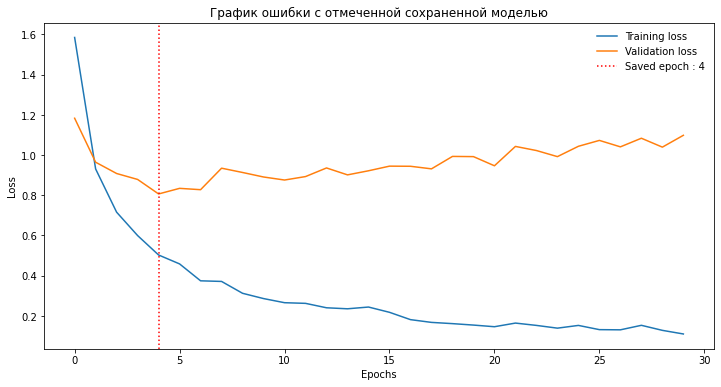

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(run_stats["train_loss"], label='Training loss')
plt.plot(run_stats["val_loss"], label='Validation loss')
plt.axvline(saved_epoch, ls=":", label=f"Saved epoch : {saved_epoch}", color="red")
plt.title('График ошибки с отмеченной сохраненной моделью')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

Как можно заметить, после 4-ой эпохи валидационная ошибка постепенно увеличивается, были предприняты различные эксперименты с попыткой уменьшить переобучение как было отмечено ранее.  Поэтому возникло ощущение малой репрезентативности (или сложности обобщения данных) классов в данных.

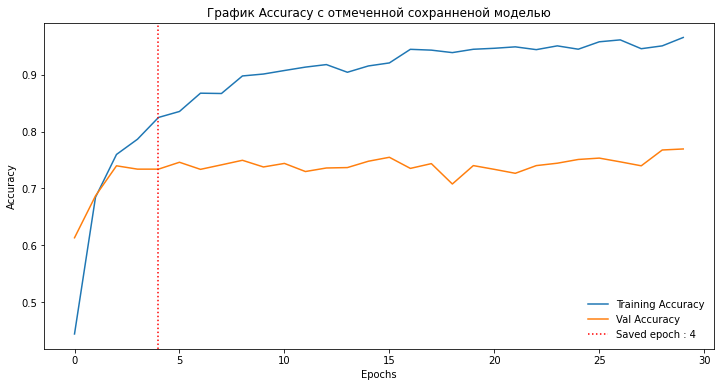

In [120]:
plt.figure(figsize=(12, 6))
plt.plot(run_stats["train_accuracy"], label='Training Accuracy')
plt.plot(run_stats["val_accuracy"], label='Val Accuracy')
plt.axvline(saved_epoch, ls=":", label=f"Saved epoch : {saved_epoch}", color="red")
plt.title('График Accuracy с отмеченной сохранненой моделью')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)

График Accuracy ожидаемо начинает увеличиваться из-за переобучения и стремится к 1.0. <br> 
Да, Accuracy не является достаточно хорошой метрикой качества, поэтому отдельно также замеряли ранее упомянутые метрики для самой лучшей модели. Также можно оценить матрицу неточностей, чтобы сравнить с какими классами возникают некоторые предсказывания.

               precision    recall  f1-score   support

      ArtDeco       0.56      0.38      0.45        13
       Cubism       0.94      0.82      0.88        73
Impressionism       0.67      0.58      0.62        48
     Japonism       0.65      0.73      0.69        41
   Naturalism       0.83      0.68      0.75        44
       Rococo       0.56      0.87      0.68        23
      cartoon       0.55      0.73      0.63        15
        photo       0.78      0.89      0.83        28

     accuracy                           0.73       285
    macro avg       0.69      0.71      0.69       285
 weighted avg       0.75      0.73      0.73       285



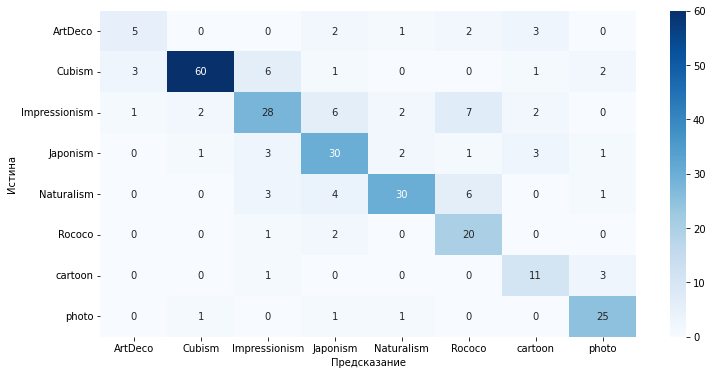

In [121]:
print(report)
plt.figure(figsize=(12, 6))

ax = sns.heatmap(cf_matrix, annot=True, xticklabels=traindata.classes, yticklabels=traindata.classes, cmap='Blues')
ax.set(xlabel='Предсказание', ylabel='Истина')
plt.show()

Наихудшие метрики у арт деко, малый recall скорее всего следствие малой представленности класса, из-за чего возникло много ложно негативных предсказаний. Немного удивлен результатом импрессионизма, но есть предположение, что класс просто очень разносторонний. В остальном же метрики для каждого класса удовлетворительные. Но стало интересно рассмотреть разницу поподробнее.

Для интерпретации результатов модели будет использован Class Activation Mappings (CAM), который выделит хитмапом область изображения на основе которого модель сделала свой выбор в сторону того или иного стиля. Большая часть кода взята из оригинала [статьи](http://cnnlocalization.csail.mit.edu/). Основная идея - прогнать изображения через модель предварительно выбрав слой с которого будут выделены активации выбранного слоя для текущего изображения. Есть различные варианты, как можно достать активации со слоя, в данном случае будем использовать метод ```nn.Module``` - ```register_forward_hook```. Хуки — это вызываемые объекты с , которые можно зарегистрировать в любом объекте ```nn.Module```. Когда метод ```forward()``` запускается в проходе модели, сам модуль вместе с его входными и выходными данными передается к ```forward_hook``` перед переходом к следующему модулю. Поскольку промежуточные слои модели имеют тип ```nn.Module```, мы можем использовать эти хуки для них, чтобы просматривать активации слоев.

In [122]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


class SaveFeatures():
    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()

    def remove(self):
        self.hook.remove()

В данном случае для корректного отображения используем ```transform_CAM```, для передачи в модель также нормализуем под среднее и отклонение ImageNet с помощью ```normalize_resnet```.

In [123]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()

transform_CAM = transforms.Compose([transforms.Resize((128, 128)),
                                    transforms.ToTensor()])
normalize_resnet = transforms.Normalize([0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])

CAM_data = datasets.ImageFolder(root="./images", transform=transform_CAM)
CAM_loader = torch.utils.data.DataLoader(CAM_data, batch_size=1, sampler=valid_sampler)

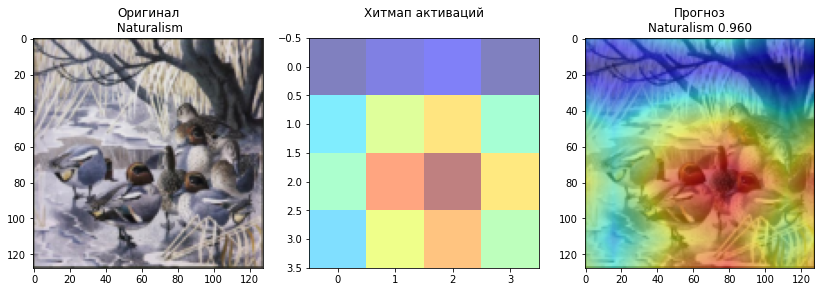

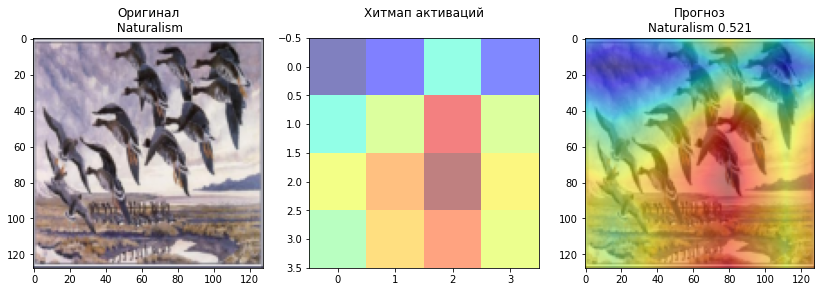

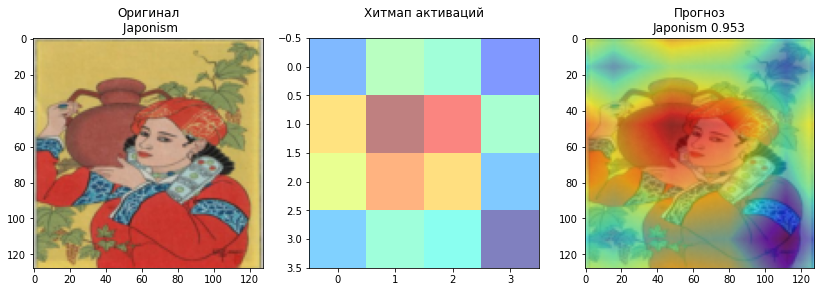

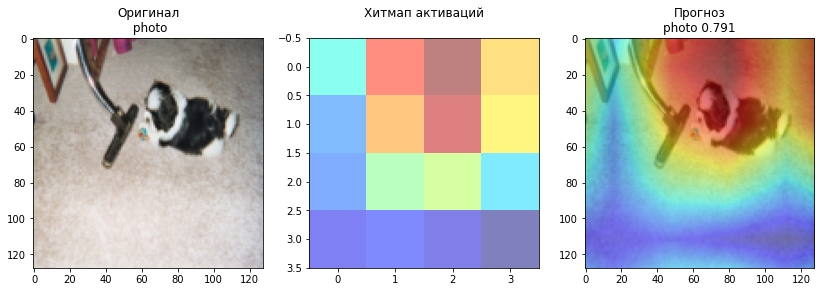

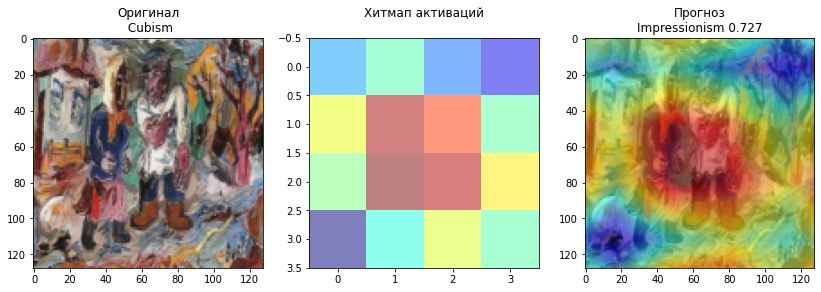

In [134]:
from torch.autograd import Variable
import skimage.transform

rows = 1
columns = 3
num_of_samples = 5

for i in range(num_of_samples):
    image = next(iter(CAM_loader))
    fig = plt.figure(figsize=(14, 7))
    fig.add_subplot(rows, columns, 1)
    original_class = CAM_data.classes[image[1].item()]
    plt.title(f"Оригинал\n {original_class}")
    temp = image[0].squeeze(0)
    plt.imshow(np.transpose(image[0].squeeze(0), (1, 2, 0)))

    display_transform = transforms.Compose([
        transforms.Resize((128, 128))])
    tensor = normalize_resnet(image[0])
    prediction_var = Variable(tensor.cuda(), requires_grad=True)

    final_layer = model._modules.get('layer4')
    activated_features = SaveFeatures(final_layer)
    prediction = model(prediction_var)
    pred_probabilities = F.softmax(prediction, dim=1).data.squeeze()
    activated_features.remove()

    weight_softmax_params = list(model._modules.get('fc').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

    class_probab, class_idx = torch.topk(pred_probabilities, 1)[0].item(), torch.topk(pred_probabilities, 1)[1].item()
    predicted_class = CAM_data.classes[class_idx]
    overlay = getCAM(activated_features.features, weight_softmax, class_idx)

    fig.add_subplot(rows, columns, 2)
    plt.title(f"Хитмап активаций\n")

    plt.imshow(overlay[0], alpha=0.5, cmap='jet')
    fig.add_subplot(rows, columns, 3)
    plt.title(f"Прогноз\n{predicted_class} {class_probab:.3f}")
    plt.imshow(np.transpose(image[0].squeeze(0), (1, 2, 0)))
    plt.imshow(skimage.transform.resize(overlay[0], (128, 128)), alpha=0.5, cmap='jet')
    plt.show()

Прогонять блок кода выше можно повторно, можно также выбрать количество картинок для анализа. На правой картинке также отображается класс с максимальный значением с классификатора.

# 2 Кластеризация с предпоследнего слоя сети


Для начала необходимо подготовить основные классы для удобства работы.<br>
```ImageFolderWithPaths``` -  фактически является переопределением  метода ```__getitem__```  в ImageFolder, в котором теперь также возвращается путь к файлу *(это нужно было чтобы смотреть какие именно картины попали не в тот кластер на plotly, однако гитхаб не поддерживает интерактивные графики, но это можно посмотреть если скачать ноутбук отдельно)* <br>
```Identity``` - нужен для прямого вывода с последнего слоя в feature vector

In [82]:
class ImageFolderWithPaths(datasets.ImageFolder):

    def __getitem__(self, index):
        sample, target = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]

        return sample, target, path


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

Оценим количество входных признаков в сеть классификатор

In [83]:
model.fc.in_features

512

Вводим вместо финального слоя классификатора новый объект Identity

In [84]:
model.fc = Identity()
model.to(device)

clusterdata = ImageFolderWithPaths(root="./images",
                                   transform=transform)
targets = clusterdata.targets
cluster_loader = torch.utils.data.DataLoader(clusterdata, batch_size=batch_size)

Сценарий сохранения feature vector и путей к картинам со всех изображений выглядит следующим образом:

In [85]:
feature_vector = []
classes = []
paths = []

with torch.no_grad():
    model.eval()

    for images, labels, img_paths in cluster_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        prob = torch.exp(output)

        if len(feature_vector) == 0:
            feature_vector = output.cpu().numpy()
            paths = list(img_paths)
        else:
            feature_vector = np.append(feature_vector, output.cpu().numpy(), axis=0)
            paths.extend(img_paths)

        class_val, class_num = prob.topk(1, dim=1)
        equal = labels == class_num.view(labels.shape)
        classes.extend(labels.tolist())

Feature vector имеет размерность 512 и для возможности визуализровать, а также для попытки избавиться от избыточного количества признаков, было решено воспользоваться методом уменьшения размерности. Для этих целей был выбран tSNE, tSNE отличается от PCA тем, что акцентирует внимание на малых попарных расстояниях или локальных сходствах, тогда как PCA занимается сохранением больших попарных расстояний для максимизации дисперсии.

Фактически мы выделим 512 признака как 2 признака по которым будем отличать полученные кластера в двумерном пространстве. Выбор метода кластеризации производился из методов с априорным знанием о количестве кластеров, наилучшими метриками (которые будут указаны ниже) обладал метод KMeans.

Помимо этого было решено стандартизировать данные с помощью ```StandardScaler```, что в дальнейшем может повлиять на результаты кластеризации

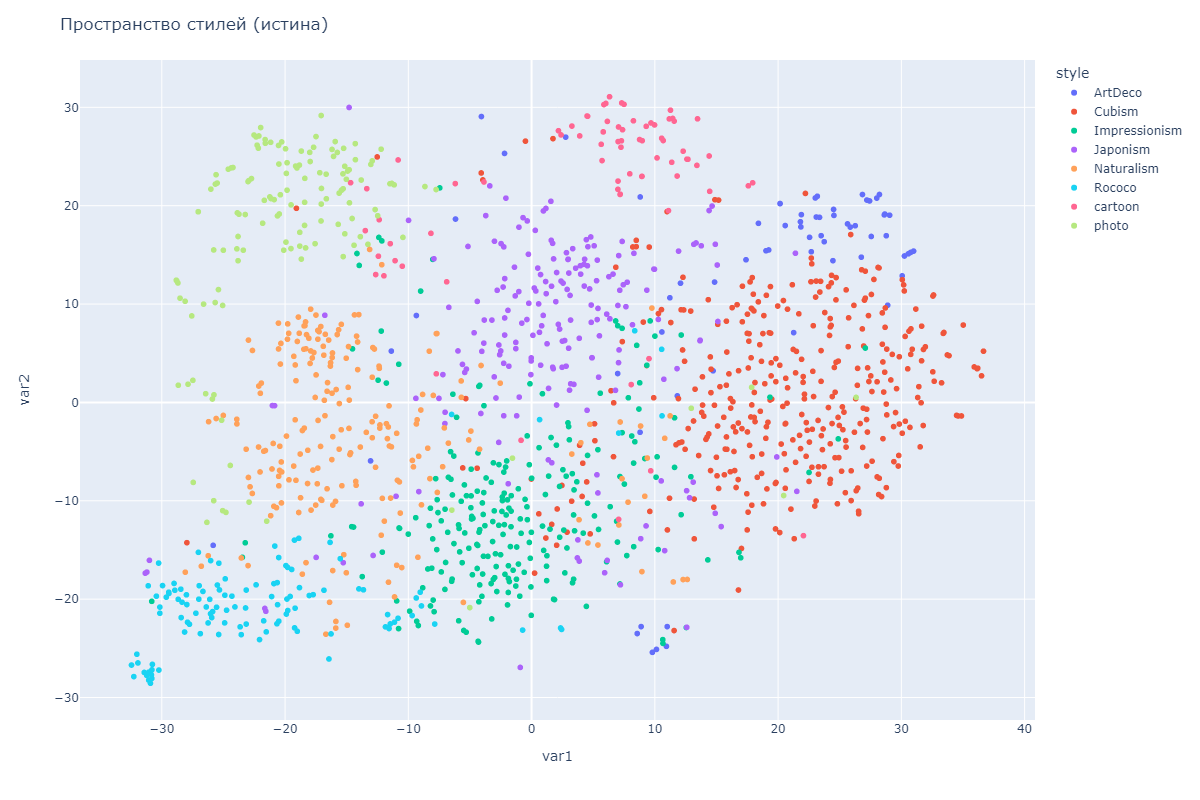

In [106]:
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from PIL import Image

pca = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1)
temp = np.copy(feature_vector)

scaler = StandardScaler()
temp = scaler.fit_transform(temp)

plotik = pca.fit_transform(temp)

styles = [clusterdata.classes[x] for x in classes]

df = pd.DataFrame(plotik, columns=["var1", "var2"])
df['target'] = classes
df['img_path'] = paths
df['style'] = styles

fig = px.scatter(df, x="var1", y="var2", color="style", hover_data=['img_path'])
fig.update_layout(
    title="Пространство стилей (истина)",
    autosize=False,
    width=1200,
    height=800)
fig

# данные 2 строки только для вывода картинки на гитхабе, в обычном ноутбуке вызовется интерактивный plotly, где можно выбрать точку и увидеть путь файла
# (было интересно посмотреть какие именно картинки попали в другие кластеры)
image = Image.open('cluster1.png')
image

Данные можно кластеризировать по крайней мере визуально можно выделить некоторые кластеры и помимо этого статистика Хопкинса показала на данных достаточно высокие результаты, об этом подробнее будет чуть ниже, когда будут описываться метрики. В любом случае можно заметить что некоторые кластеры накладываются друг на друга, а также есть аномальные картины, которые явно выделяются. 
P.S. Точки выделяются интерактивно и можно посмотреть какая именно картина относится к этой точке, но в гитхабе это не отображается, можно убрать две последние строчки и посмотреть в plotly

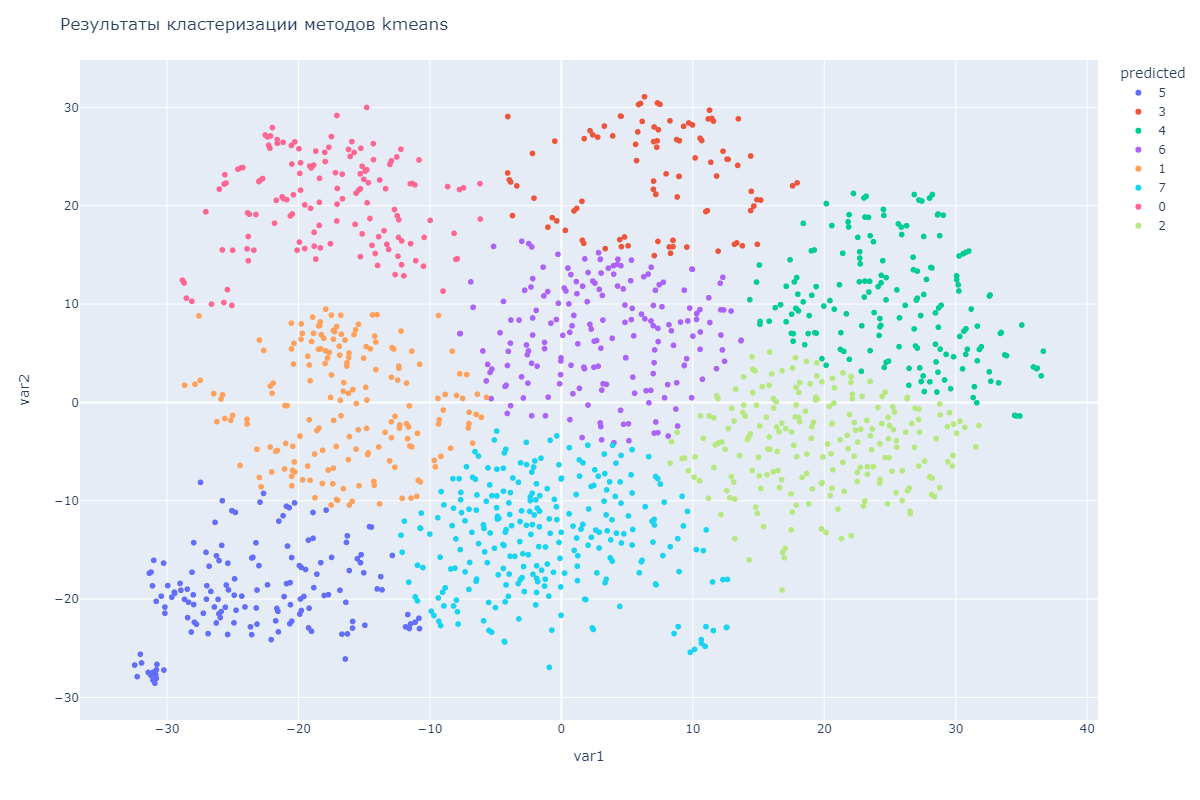

In [107]:
from sklearn.cluster import KMeans

temp = df[['var1', 'var2', ]].to_numpy()
kmeans = KMeans(n_clusters=8).fit_predict(temp)

df['predicted'] = kmeans
df['predicted'] = df['predicted'].astype(str)
fig = px.scatter(df, x="var1", y="var2", color="predicted", hover_data=['img_path'])
fig.update_layout(
    title="Результаты кластеризации методов kmeans",
    autosize=False,
    width=1200,
    height=800)
fig

# данные 2 строки только для вывода картинки на гитхабе, в обычном ноутбуке вызовется интерактивный plotly, где можно выбрать точку и увидеть путь файла 
# (было интересно посмотреть какие именно картинки попали в другие кластеры)
image = Image.open('cluster2.png')
image


Переходя к различным метрикам хотелось проверить несколько показателей, одним из них является вышеупомянутая статистика Хопкинска, которая показывает тенденцию данных к кластеризации, обычно результат выше 0.7 демонстрирует высокую тенденцию. В питоне в распространненых библиотеках реализации не увидел, поэтому взял простой реализованный [вариант](https://github.com/mhatim99/Hopkins-Test/blob/master/Hopkins%20Test.ipynb)

In [88]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan


def hopkins(X):
    d = X.shape[1]
    # d = len(vars) # columns
    n = len(X)  # rows
    m = int(0.1 * n)  # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X, axis=0), np.amax(X, axis=0), d).reshape(1, -1), 2,
                                    return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

Помимо статистики Хопкинска необходимо проверить еще метрики оценивающие качество кластеризации.
Для этого были выбраны метрики adjusted mutual info (AMI) и silhouette score.

Метрика adjusted Rand index обычно используется в кластерах без дисбаланса данных, в данном случае результат был примерно 0.44, когда значения меньше 0.65 обычно считаются не очень хорошим результатом. Похожей метрикой является AMI и она предусматривает возможность работы с несбалансированными данными.

AMI -  оценка взаимной информация для двух распределений, соответствующих разбиениям  на кластеры. (0 - нет взаимной информации, 1 - полное соответствие )

Silhouette  score - оценка того, насколько объект похож на свой собственный кластер (компактность) по сравнению с другими кластерами (разделимость). Оценка варьируется от −1 до +1.


In [89]:
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import silhouette_score

print('Hopkins=', hopkins(df[['var1', 'var2']]))
print("AMI=", adjusted_mutual_info_score(kmeans, df['target']))
print("Silhoutette score=", silhouette_score(temp, kmeans, metric='euclidean'))

Hopkins= 0.7785784437321388
AMI= 0.5117844896229523
Silhoutette score= 0.41480455


Как было сказано ранее, статистика Хопкинса при значении > 0.7 демонстрирует высокую тенденцию к кластеризации, что здесь и заметно. <br>
Silhouette score - 0.41 в целом считается средним результатом, например датасет Ирисов при 3 кластерах = 0.55. <br>
AMI - 0.51 оценить сложнее, но можно оценить как средний результат, так как взаимная информация присутствует, но равносильно удаленно от значения 1.

# 3 Градиентный бустинг


Для градиентного бустинга был выбран ```XGBoost```, был создан мини пайплайн с поиском оптимальных гиперпараметров с помощью ```GridSearchCV```, для кросс-валидации использовался ```StratifiedKFold```.

In [90]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb

X_train = df.iloc[train_idx]
X_test = df.iloc[test_idx]

scorers = {
    'f1_score': make_scorer(f1_score, average='micro'),
    'precision_score': make_scorer(precision_score, average='micro'),
    'recall_score': make_scorer(recall_score, average='micro'),
    'accuracy_score': make_scorer(accuracy_score)
}
xgb_model = xgb.XGBClassifier(n_jobs=-1, objective='multi:softmax', use_label_encoder='False')
param_dist = {'n_estimators': np.arange(50, 450, 100),
              'learning_rate': np.arange(0.01, 0.35, 0.10),
              'subsample': np.arange(0.4, 1, 0.2),
              'max_depth': np.arange(5, 8, 1),
              'min_child_weight': np.arange(1, 7, 2)
              }

skf = StratifiedKFold(n_splits=3, shuffle=True)
gridCV = GridSearchCV(xgb_model,
                      param_grid=param_dist,
                      cv=skf,
                      scoring=scorers,
                      verbose=3,
                      n_jobs=-1,
                      return_train_score=True,
                      refit='f1_score')
gridCV.fit(X_train[['var1', 'var2']], X_train['target'])

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[13:57:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min...
                         'min_child_weight': array([1, 3, 5]),
                         'n_estimators': array([ 50, 150, 250, 350]),
                         'subsample': array([0.4, 0.6, 0.8])},
             refit='f1_score', return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score),


               precision    recall  f1-score   support

      ArtDeco       0.57      0.31      0.40        13
       Cubism       0.78      0.84      0.81        73
Impressionism       0.60      0.60      0.60        48
     Japonism       0.63      0.63      0.63        41
   Naturalism       0.70      0.75      0.73        44
       Rococo       0.76      0.83      0.79        23
      cartoon       0.80      0.53      0.64        15
        photo       0.76      0.79      0.77        28

     accuracy                           0.71       285
    macro avg       0.70      0.66      0.67       285
 weighted avg       0.71      0.71      0.70       285

Лучшие найденные параметры:
 {'learning_rate': 0.11, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.6000000000000001}


[Text(0.5, 33.0, 'Предсказание'), Text(87.0, 0.5, 'Истина')]

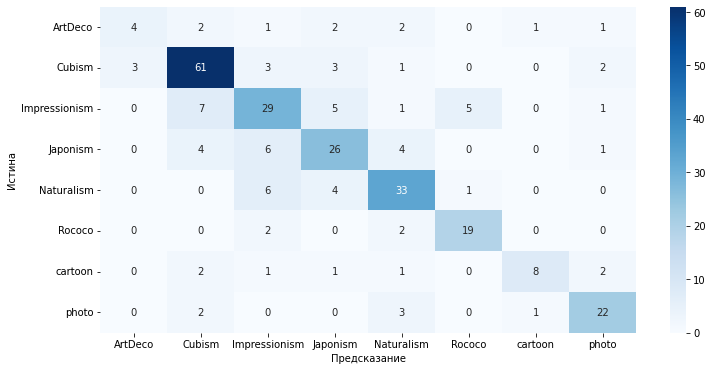

In [101]:
preds = gridCV.best_estimator_.predict(X_test[['var1', 'var2']])
report_xgb = classification_report(X_test['target'], preds, target_names=traindata.classes)
print(report_xgb)

print("Лучшие найденные параметры:\n", gridCV.best_params_)
cf_matrix_xgb = confusion_matrix(X_test['target'], preds)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(cf_matrix_xgb, annot=True, xticklabels=traindata.classes, yticklabels=traindata.classes, cmap='Blues')
ax.set(xlabel='Предсказание', ylabel='Истина')

Как можно заметить метрики качества в обоих случаях схожи с выводом модели с пункта 1.<br>
Различия лишь внутри отдельных классов.<br>
Можно подробнее сравнить две таблицы.<br>

In [102]:
print("Отчет с нейронной сети")
print(report)


Отчет с нейронной сети
               precision    recall  f1-score   support

      ArtDeco       0.56      0.38      0.45        13
       Cubism       0.94      0.82      0.88        73
Impressionism       0.67      0.58      0.62        48
     Japonism       0.65      0.73      0.69        41
   Naturalism       0.83      0.68      0.75        44
       Rococo       0.56      0.87      0.68        23
      cartoon       0.55      0.73      0.63        15
        photo       0.78      0.89      0.83        28

     accuracy                           0.73       285
    macro avg       0.69      0.71      0.69       285
 weighted avg       0.75      0.73      0.73       285



In [103]:
print("Отчет с градиентного бустинга")
print(report_xgb)

Отчет с градиентного бустинга
               precision    recall  f1-score   support

      ArtDeco       0.57      0.31      0.40        13
       Cubism       0.78      0.84      0.81        73
Impressionism       0.60      0.60      0.60        48
     Japonism       0.63      0.63      0.63        41
   Naturalism       0.70      0.75      0.73        44
       Rococo       0.76      0.83      0.79        23
      cartoon       0.80      0.53      0.64        15
        photo       0.76      0.79      0.77        28

     accuracy                           0.71       285
    macro avg       0.70      0.66      0.67       285
 weighted avg       0.71      0.71      0.70       285



# Приложение
### Реализация Resnet18 с  Dropout

In [104]:

class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

class Res18Drop(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(Res18Drop, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)


        self.dropout = nn.Dropout(p=0.5)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.dropout(self.layer1(x))
        x = self.dropout(self.layer2(x))
        x = self.dropout(self.layer3(x))
        x = self.dropout(self.layer4(x))
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )
    